# Import and Install

In [2]:
pip install git+https://github.com/csebuetnlp/normalizer -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install datasets -q

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from normalizer import normalize
from datasets import load_dataset
import torch
import numpy as np
import pandas as pd

# Loading Dataframe

In [1]:
import pandas as pd
df = pd.read_csv("/kaggle/input/openai-imdb-1k/openai_bengali_translation-1000.csv")
df = df.iloc[:1000]

In [5]:
df

,review,translated,sentiment
0,One of the other reviewers has mentioned that ...,"একজন অন্য রিভিউয়ার বলেছেন যে, কেবল 1 টি ওজ এপ...",positive
1,A wonderful little production. <br /><br />The...,একটি অসাধারণ ছোট প্রস্তুতি। <br /><br />ফিল্মি...,positive
2,I thought this was a wonderful way to spend ti...,আমি মনে করি এটি একটি অত্যন্ত গরম গ্রীষ্মকালীন ...,positive
3,Basically there's a family where a little boy ...,মূলত এখানে একটি পরিবার আছে যেখানে একটি ছোট ছেল...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...","পেটার মাটেইর ""লাভ ইন দ্য টাইম অব মানি"" দেখা এক...",positive
...,...,...,...
995,Nothing is sacred. Just ask Ernie Fosselius. T...,কোনও কিছু পবিত্র নয়। শুধু একটি উদাহরণ দিন এরন...,positive
996,I hated it. I hate self-aware pretentious inan...,আমি এটা ঘৃণা করছিলাম। আমি স্ব-সচেতন মিথ্যাবাদী...,negative
997,I usually try to be professional and construct...,আমি সাধারণভাবে চলচ্চিত্র সমীক্ষা করার সময়ে পে...,negative
998,If you like me is going to see this in a film ...,আপনি যদি আমার মতে এই চিত্রটি আপনার স্কুলের একট...,negative


In [6]:
from datasets import Dataset, DatasetDict
train_df, valid_df = train_test_split(df, test_size = 0.3)
val_df, test_df = train_test_split(valid_df, test_size = 0.5)

In [7]:
train_df

,review,translated,sentiment
79,This film took me by surprise. I make it a hab...,এই চলচ্চিত্রটি আমাকে অবাক করে নিয়েছিল। আমি সা...,positive
835,The story has been told before. A deadly disea...,গল্পটি আগেও বলা হয়েছে। একটি মরণোপদ্বেষ্টা রোগ...,positive
773,"Even this early in his career, Capra was quite...","এমনটা তার ক্যারিয়ারের প্রারম্ভিক দিনেই, ক্যাপ...",positive
504,This is one of my all time favorite movies and...,এটি আমার সবসময়ের প্রিয় চলচ্চিত্র গুলির একটি ...,positive
19,An awful film! It must have been up against so...,একটি খারাপ চলচ্চিত্র! গোল্ডেন গ্লোবের জন্য নাম...,negative
...,...,...,...
156,From the film's first shot - Keira Knightley a...,ছবির প্রথম শট - কিরা নাইটলি যে এলিজাবেথ বেনেট ...,negative
467,I like this movie because it is a fine work of...,আমি এই চলচ্চিত্রটি পছন্দ করি কারণ এটি একটি চিত...,positive
788,Years ago I saw The Godfather and it made a la...,বহু বছর আগে আমি দি গডফাদার দেখেছিলাম এবং তা আম...,negative
130,Two hours ago I was watching this brilliant mo...,দুই ঘন্টা আগে আমি এই অসাধারণ চলচ্চিত্রটি দেখছি...,positive


# Tokenization

In [8]:
checkpoint = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
max_length = 256

In [10]:
train_encodings = tokenizer(
    [normalize(sentence) for sentence in train_df.translated], 
    truncation=True,
    padding=True,
    max_length=max_length
)

val_encodings = tokenizer(
    [normalize(sentence) for sentence in valid_df.translated], 
    truncation=True,
    padding=True,
    max_length=max_length
)

test_encodings = tokenizer(
    [normalize(sentence) for sentence in test_df.translated], 
    truncation=True,
    padding=True,
    max_length=max_length
)

In [11]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [12]:
train_labels = [0 if row.sentiment == "positive" else 1 for idx, row in train_df.iterrows()]
train_dataset = SentimentDataset(train_encodings, train_labels)
val_labels = [0 if row.sentiment == "positive" else 1 for idx, row in valid_df.iterrows()]
val_dataset = SentimentDataset(val_encodings, val_labels)
test_labels = [0 if row.sentiment == "positive" else 1 for idx, row in test_df.iterrows()]
test_dataset = SentimentDataset(test_encodings, test_labels)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    learning_rate=4e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,  
    evaluation_strategy="epoch",  
    save_strategy="epoch", 
    report_to=["none"]
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Training

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.691700,0.688666,0.556667,0.387097,0.656250,0.274510
2,0.677900,0.645322,0.720000,0.671875,0.834951,0.562092
3,0.448200,0.420741,0.850000,0.844291,0.897059,0.797386
4,0.320300,0.438082,0.826667,0.812950,0.904000,0.738562
5,0.285000,0.488877,0.826667,0.807407,0.931624,0.712418
6,0.136700,0.414928,0.866667,0.864865,0.895105,0.836601
7,0.096800,0.565312,0.850000,0.858044,0.829268,0.888889
8,0.054200,0.711688,0.823333,0.812721,0.884615,0.751634
9,0.013800,0.858276,0.843333,0.862974,0.778947,0.967320
10,0.002700,0.827232,0.850000,0.852459,0.855263,0.849673


TrainOutput(global_step=660, training_loss=0.18835429221067126, metrics={'train_runtime': 332.3449, 'train_samples_per_second': 31.594, 'train_steps_per_second': 1.986, 'total_flos': 1381333040640000.0, 'train_loss': 0.18835429221067126, 'epoch': 15.0})

# Result

In [18]:
eval_results = trainer.evaluate()

print("\n" + "="*40)
print("    Evaluation Results".center(40))
print("="*40)

for key, value in eval_results.items():
    print(f"{key.replace('_', ' ').title():<35}: {value:>8.4f}")

print("="*4)


             Evaluation Results         
Eval Loss                          :   1.0405
Eval Accuracy                      :   0.8500
Eval F1                            :   0.8410
Eval Precision                     :   0.9154
Eval Recall                        :   0.7778
Eval Runtime                       :   2.2987
Eval Samples Per Second            : 130.5080
Eval Steps Per Second              :  16.5310
Epoch                              :  15.0000
====


In [19]:
predictions_output = trainer.predict(test_dataset)

In [20]:
metrics = predictions_output.metrics

print("\n" + "="*40)
print("           Prediction Metrics".center(40))
print("="*40)

for key, value in metrics.items():
    print(f"{key.replace('_', ' ').title():<35}: {value:>8.4f}")

print("="*40)


                Prediction Metrics      
Test Loss                          :   1.0153
Test Accuracy                      :   0.8467
Test F1                            :   0.8321
Test Precision                     :   0.9344
Test Recall                        :   0.7500
Test Runtime                       :   1.1652
Test Samples Per Second            : 128.7350
Test Steps Per Second              :  16.3060


# Confusion Matrix

In [21]:
predictions_output = trainer.predict(val_dataset)

logits = predictions_output.predictions
true_labels = predictions_output.label_ids

predictions = logits.argmax(axis=-1)

Confusion Matrix:
[[136  11]
 [ 34 119]]


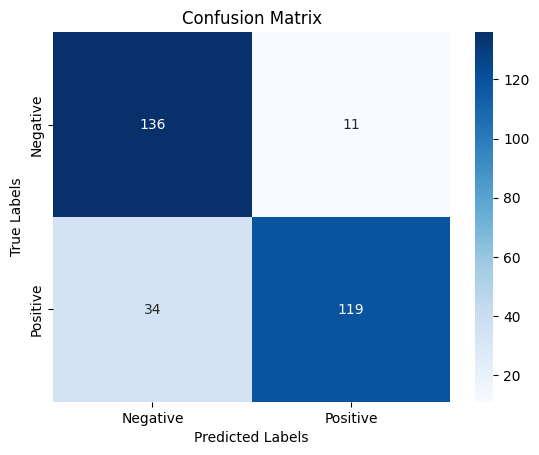

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = logits.argmax(axis=-1)

conf_matrix = confusion_matrix(true_labels, predictions)

print("Confusion Matrix:")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()